In [2]:
import pyredner
import torch
import linAlgHelper
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import open3d as o3d
from scipy.spatial import ConvexHull, HalfspaceIntersection
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import numpy as np
import trimesh as tm
from scipy.spatial import ConvexHull
from neuralVolumeHelper import randCam, matrixLookat, createInputVector_planeHitModel,HiddenPrints, SIREN, getView, circular2sinCosC,bound2Mesh, compare2CenteredModels, bound2Pointcloud, meshIt, modelCenterCorrection, getPredictionPoints,compare2CenteredModels, bound2bounds, meshBoundsTM, mesh2pointcloud, array2Pointcloud

In [ ]:
objects = pyredner.load_obj('/home/jhm/Documents/redner-master/tutorials/teapot.obj', return_objects=True)
camera = randCam()
scene = pyredner.Scene(camera = camera, objects = objects)
light = pyredner.PointLight(position = (camera.position + torch.tensor((0.0, 0.0, 100.0))).to(pyredner.get_device()),
                                                intensity = torch.tensor((20000.0, 30000.0, 20000.0), device = pyredner.get_device()))
img = pyredner.render_deferred(scene = scene, lights = [light])
from matplotlib.pyplot import imshow
%matplotlib inline
# Gamma correction to convert the image from linear space to sRGB
imshow(torch.pow(img, 1.0/2.2).cpu())

In [2]:
#absolute values of x,y,z
#now we only have to get the camera-pixel-vectors

In [3]:
camera.position

NameError: name 'camera' is not defined

In [4]:
camera.look_at

NameError: name 'camera' is not defined

In [ ]:
camera.fov ##fov is for resolution[1]

In [ ]:
camera.resolution

In [ ]:
degreePPx = camera.fov/camera.resolution[1]

In [ ]:
x = torch.arange(camera.resolution[1]).repeat(camera.resolution[0],1)-camera.resolution[1]//2
y = (-torch.arange(camera.resolution[0]).repeat(camera.resolution[1],1)+camera.resolution[0]//2).permute(1,0)

x = torch.deg2rad(x*degreePPx)
y = torch.deg2rad(y*degreePPx)

In [ ]:
delta_normals = torch.stack([x, y, torch.ones_like(x)],-1)
oldshape = delta_normals.shape

In [ ]:

delta_normals = linAlgHelper.asCartesian(delta_normals.reshape(-1,3))

In [ ]:
#vector 0 0 1 will be cam_normal

In [ ]:
rotMatrix = matrixLookat(camera.position, camera.look_at, camera.up)

In [ ]:
(rotMatrix@delta_normals[:,:,None]).reshape(oldshape)[240,300,:]

In [ ]:
cam_normal

# create Vector representation of hitting the plane of the Volumetric

In [ ]:
vecCam2CenterNorm = linAlgHelper.p2NormLastDim(vecCam2Center)

#a und b sind die normen von cam2center und camvector
#a dot b = a_norm b_norm cos(y)
# cos(y) = a dot b / (a_length b_length) = a dot b
# len(camvector_full) = cam2center_fullLength/cos(y)
#inputVector = cam2center_full - len(camvector_full)*b  

In [ ]:
#test

camPos = torch.tensor([[5,5.,0]])
center = torch.tensor([[2.,2,0]])
camVectorNorm = torch.tensor([[-1.,0.,-0.0],[0.,-1.,-0.0],[-1.,-1.,-0.]])
lenCamVector = ((camVectorNorm**2).sum(dim=1)**0.5)[:,None]
camVectorNorm = camVectorNorm/lenCamVector
vectors = createInputVector_planeHitModel(center, camPos, camVectorNorm)
linAlgHelper.asSpherical(vectors)

In [ ]:
vecCam2Center_FULL = camPos - center
vecCam2Center_length = (vecCam2Center_FULL**2).sum(dim=-1)**0.5
vecCam2Center_norm = vecCam2Center_FULL/vecCam2Center_length[:,None]

In [ ]:
cosalpha = camVectorNorm@vecCam2Center_norm.permute(1,0)

In [ ]:
lenCamVectorFULL = vecCam2Center_length/cosalpha

In [ ]:
lenCamVectorFULL

In [ ]:
returnedVec = vecCam2Center_FULL- lenCamVectorFULL*camVectorNorm

In [ ]:
returnedVec@vecCam2Center_norm.permute(1,0) #müsste 0 sein, da die beiden im rechten winkel sind

In [ ]:
returnedVec

In [ ]:
vecCam2Center_norm

# creating a Differentiable Volume Border

In [ ]:
planeNormals = torch.tensor([[-1.,0,0],[0,-1,0.],[0.,0.,-1.],[1.,0.,0.],[0.,1,0.], [0,0,1]])

In [ ]:
points = torch.tensor([[0.5,0.5,0.5],[2,2,0],[1,1,1],[0.9,0.9,1.1]])

In [ ]:
planeNormals.cross(points.permute(1,0))

In [ ]:
planeNormals[0].dot(points[3])

In [ ]:
outputTests = linAlgHelper.getPointDistances2PlaneNormal(points[None,:,:], planeNormals[None,:,:])
outputTests

In [ ]:
#irgendeiner negativ --> ausserhalb
(torch.tanh(outputTests*10)+1).prod(dim=2)

In [ ]:
hardCutOff = torch.sigmoid((outputTests+0.01)*256).prod(dim=2) #route all point-losses through this in the end
softCutOff = torch.sigmoid((outputTests+0.01)).prod(dim=2) #route all point-losses through this in the end if inner loss is high
print(hardCutOff)
print(hardCutOff*softCutOff)

In [ ]:
#constrain boundarys to build a convex volume
planeNormals[0,0].clamp(-99999,-0.01)
planeNormals[3,0].clamp(0.01,99999)
planeNormals[1,1].clamp(-99999,-0.01)
planeNormals[4,1].clamp(0.01,99999)
planeNormals[2,2].clamp(-99999,-0.01)
planeNormals[5,2].clamp(0.01,99999)

# pressure to expand the boundary:
win for volume  
win for every matched point * boundary  
loss for every unmatched point * boundary   

cycle through big/small weigths in win/loss

# build the Volume

In [ ]:


class convexNeuralVolume(nn.Module):
    def __init__(self, center= torch.tensor([0.,0.,0.], requires_grad=True), model=SIREN([3,32,32,1])):
        super(convexNeuralVolume,self).__init__()
        self.bounds= nn.Parameter(torch.tensor([[-1.,0.,0.],[0,-1,0.],[0.,0.,-1.],[1.,0.,0.],[0.,1,0.], [0.,0.,1]], requires_grad=True).cuda())
        self.center = nn.Parameter(center.cuda())
        self.model = model.cuda()
        #self.shapeCode = torch.rand((1,32),requires_grad=True)
    
    def forwardBad(self,x, camPos, points):
        centered_points = points-self.center
        #points are more or less the target and input for the boundary computation
        inputVectorsXYZ = createInputVector_planeHitModel(self.center, camPos, x)
        inputVectorsTAR = linAlgHelper.asSpherical(vectors)
        '''forward pass input: NormedCameraVectors_WorldCoord x [Number,xyz]; Vectors are already preselected for hitting near the bounds (bounds+constants) - maybe by lsh'''
        boundsTest = linAlgHelper.getPointDistances2PlaneNormal(centered_points[None,:,:], self.bounds[None,:,:])
        hardCutOff = torch.sigmoid((boundsTest+0.01)*256).prod(dim=2) #route all point-losses through this in the end
        softCutOff = torch.sigmoid((boundsTest+0.01)).prod(dim=2) #route all point-losses through this in the end if inner loss is high
        distances = self.model(circular2sinCos(inputVectorsTAR))
        targetDistances = ((centered_points-inputVectorsXYZ)**2).sum(dim=1)**0.5
        error = -softCutOff.sum() +(40*abs(distances-targetDistances)*hardCutOff*softCutOff).sum()
        return distances, error
    
    def forward(self,x):
        centered_points = x-self.center
        inputVectorsTAR = linAlgHelper.asSpherical(centered_points)
        #ensure a valid convex bound that is not 0
        with torch.no_grad():
            self.bounds[0,0].clamp(-99999,-0.01)
            self.bounds[3,0].clamp(0.01,99999)
            self.bounds[1,1].clamp(-99999,-0.01)
            self.bounds[4,1].clamp(0.01,99999)
            self.bounds[2,2].clamp(-99999,-0.01)
            self.bounds[5,2].clamp(0.01,99999)
        '''forward pass input: NormedCameraVectors_WorldCoord x [Number,xyz]; Vectors are already preselected for hitting near the bounds (bounds+constants) - maybe by lsh'''
        boundsTest = linAlgHelper.getPointDistances2PlaneNormal(centered_points[None,:,:], self.bounds[None,:,:])
        hardCutOff = torch.sigmoid((boundsTest+0.01)*256).prod(dim=2) #route all point-losses through this in the end
        softCutOff = torch.sigmoid((boundsTest+0.01)).prod(dim=2) #route all point-losses through this in the end if inner loss is high
        modelInput = circular2sinCos(inputVectorsTAR[:,:2])
        #print(modelInput.shape)
        distances = self.model(modelInput)[:,0]
        error = -softCutOff.sum() +(40*abs(distances-inputVectorsTAR[:,2])*(hardCutOff*softCutOff)[0,:]).sum()
        return distances.detach().abs(), error
    
    def mesh(self, simple=True):
        ball = tm.primitives.Capsule(radius=1., height=0.,sections=100)
        sphericalInput = linAlgHelper.asSpherical(torch.tensor(ball.vertices).float())[:,:2].cuda()
        circularOut = circular2sinCos(sphericalInput)
        with torch.no_grad():
            if simple:
                distances = self.model(circularOut.cuda()).abs()
            else:
                circularOut = torch.cat((circularOut,torch.ones_like(circularOut[:,0])*0.005),dim=1)
                distances = self.model(circularOut)
            predictedSpherical = torch.cat((sphericalInput,distances),dim=1)
            points = linAlgHelper.asCartesian(predictedSpherical).cpu()
            #distances2Bounds = linAlgHelper.getPointDistances2PlaneNormal(points[None,:,:], self.bounds[None,:,:])
            #wenn etwas negativ ist, berechne das dreieck ankathete-bound, hypotenusenvektor-punkt
        
        return points, torch.tensor(ball.faces)
        

In [ ]:
ball = tm.primitives.Capsule(radius=1., height=0.,sections=100)
sphericalInput = linAlgHelper.asSpherical(torch.tensor(ball.vertices).float())[:,:2]
circularOut = circular2sinCos(sphericalInput)
circularOut

In [ ]:
sphericalInput.min(dim=0)

In [ ]:
plt.scatter(torch.arange(1000),torch.sin(torch.linspace(-np.pi,np.pi,1000)))
plt.scatter(torch.arange(1000),torch.cos(torch.linspace(-np.pi,np.pi,1000)))

# train one convex Volume

In [4]:
import trimesh as tm

In [5]:
volume = convexNeuralVolume(model=SIREN([3,32,32,1], dynScale=False))
with torch.no_grad():
    objects = pyredner.load_obj('/home/jhm/Documents/redner-master/tutorials/teapot.obj', return_objects=True)


NameError: name 'convexNeuralVolume' is not defined

In [6]:
import open3d as o3d
# initial view
vertices, faces = volume.mesh()
mesh = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(np.array(vertices)),
                          triangles= o3d.utility.Vector3iVector(faces))
mesh.compute_vertex_normals()
#mesh.compute_triangle_normals()
mesh.paint_uniform_color([1, 0.706, 0])
o3d.visualization.draw_geometries([mesh])

NameError: name 'volume' is not defined

In [ ]:
pos[mask].detach()

In [ ]:
vertices, faces = volume.mesh()
mesh = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(np.array(vertices)),
                          triangles= o3d.utility.Vector3iVector(faces))
mesh.compute_vertex_normals()
#mesh.compute_triangle_normals()
mesh.paint_uniform_color([1, 0.706, 0])
pointcloud = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(pos[mask].detach().cpu()))
o3d.visualization.draw_geometries([pointcloud,mesh])

In [ ]:
pointcloud = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(pos[mask].detach().cpu()))
o3d.visualization.draw_geometries([pointcloud,mesh])

In [ ]:
volume.bounds

In [ ]:
volume.center

In [ ]:
paraSum = 0
for para in volume.parameters():
    paraSum += para.numel()
paraSum

In [ ]:
paraSum = 0
for para in volume.model.parameters():
    paraSum += para.numel()
paraSum

In [ ]:
import open3d as o3d
pcd=o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(torch.rand((15,3))))

In [ ]:
o3d.visualization.draw_geometries([pcd])


# einzeltest des bounds adjustments

Drei voneinander unabhängige bounds gehen gut, die 4 scheitert. Warum?  
These: Die Ebenen betrachten durch den soft-cutoff auch die Punkte, die die Rückseitenebene blocken sollte  
- nur die Punkte im Volumen beim inner-loss betrachten  
- nur die Punkte ausserhalb der betrachteten Ebene beim Gain betrachten

In [7]:
#center in 0,0, nur eine bound(plane)

planeNr = 6

targetbound = torch.Tensor([[0.,0.5,1.],[0.,1.,0.],[2.,0.,0.],[0.,-1.4,0.],[-1.,0.,0.],[0.,0.,-1.]])
data = torch.rand(5000,3)*6.-3.
boundsTest = linAlgHelper.getPointDistances2PlaneNormal(data[None,:,:], targetbound[None,:,:])
value = torch.rand(5000,1) 
value = torch.ones(5000,1)
value[((boundsTest[0,:,:] > 0)*1).sum(dim=1)==planeNr,:] = -value[((boundsTest[0,:,:] > 0)*1).sum(dim=1)==planeNr,:]
bound = torch.rand((planeNr,3), requires_grad=True)
optim = torch.optim.Adam([bound], lr=0.1)

In [8]:
for i in range(10000):
    optim.zero_grad()
    boundsTest = linAlgHelper.getPointDistances2PlaneNormal(data[None,:,:], bound[None,:,:])[0]
    with torch.no_grad():
        inside = boundsTest>0
        near = abs(boundsTest)>0.15 #könnte von der länge der ebene abhängig gemacht werden
        importance = 0.1/(0.1+abs(boundsTest)) #könnte von der länge der ebene abhängig gemacht werden
        completeInner = inside.sum(dim=1)==planeNr
        
        bound[0,0].clamp(-99999,-0.01)
        bound[3,0].clamp(0.01,99999)
        bound[1,1].clamp(-99999,-0.01)
        bound[4,1].clamp(0.01,99999)
        bound[2,2].clamp(-99999,-0.01)
        bound[5,2].clamp(0.01,99999)
    #hardCutOff = torch.sigmoid((boundsTest+0.01)*256).prod(dim=1) #route all point-losses through this in the end
    insideError = torch.sigmoid(boundsTest*8) #könnte von der länge der ebene abhängig gemacht werden
    valueMissed = -value*(1-inside*1)
    errorGreed = (((1.-insideError)*valueMissed*importance)[value[:,0]<0])
    # for the inner loss: errors near a plane are important, but the gradient of the error should shrink, the nearer it gets
    wrongValues = value*completeInner[:,None]
    innerLoss= (importance**2*wrongValues*insideError)[value[:,0]>0]
    #outside = 1.-hardCutOff[0,:]
    #greedyGains = torch.relu(-value[:,0]*outside* (1.-softCutOff[0,:])).sum() #vorhersagen aussen erreichen
    #innerLoss = torch.relu(value[:,0]*((hardCutOff*softCutOff)[0,:])).sum()  #fehler innen vermeiden
    #expansionGain = - #expansionsdrang
    #bestSeparation = -((-value)*(insideError-0.5)*importance**2)[near]
    error = errorGreed.sum() +innerLoss.sum()#+ bestSeparation.sum()
    error.backward()
    optim.step()
    # gradients should be fine, but the size of the error will be all over the place
    #measurement should be done by 
    with torch.no_grad():
        wrongValueInside = wrongValues[value[:,0]>0].sum()
        rightValuesOutside = valueMissed[value[:,0]<0].sum()
        
    if i % 500 == 0:
            print(bound.detach(), "gainsMissed: ",rightValuesOutside.item(),"innerLoss: ",wrongValueInside.item())

tensor([[ 0.9593,  0.7738, -0.0600],
        [ 0.4162, -0.0670,  0.5548],
        [ 0.1885,  0.3352,  0.3370],
        [ 0.2046,  0.7429, -0.0334],
        [ 0.2731,  0.6013, -0.0269],
        [ 0.3220,  0.9989,  0.3358]]) gainsMissed:  605.0 innerLoss:  2009.0
tensor([[ 5.1949e-03, -5.8108e-03, -1.0045e+00],
        [ 1.8453e-02, -1.3918e+00, -4.1656e-05],
        [-1.7090e-02,  4.8633e-01,  9.9434e-01],
        [ 3.6044e-03,  1.0042e+00, -4.8735e-02],
        [-1.0399e+00, -7.3109e-02,  1.3574e-02],
        [ 2.0062e+00, -2.3574e-02,  1.3282e-02]]) gainsMissed:  0.0 innerLoss:  0.0
tensor([[ 5.1949e-03, -5.8108e-03, -1.0045e+00],
        [ 1.8453e-02, -1.3918e+00, -4.1656e-05],
        [-1.7090e-02,  4.8633e-01,  9.9434e-01],
        [ 3.6044e-03,  1.0042e+00, -4.8735e-02],
        [-1.0399e+00, -7.3109e-02,  1.3574e-02],
        [ 2.0062e+00, -2.3574e-02,  1.3282e-02]]) gainsMissed:  0.0 innerLoss:  0.0
tensor([[ 5.1949e-03, -5.8108e-03, -1.0045e+00],
        [ 1.8453e-02, -1.3918e+

KeyboardInterrupt: 

Als gradienten brauchen die inner-losses den folgenden distanzskalierungsfaktor:

In [ ]:
dis = torch.linspace(-1,1.,100)
plt.plot(dis,torch.sigmoid((dis)*8))#*torch.sigmoid(-dis*0.2))

In [ ]:
plt.plot(dis,0.1/(0.1+dis))

# Test mit verschiebbarem Zentrum

In [ ]:
#center in 0,0, nur eine bound(plane)

planeNr = 6

targetbound = torch.Tensor([[0.,0.5,1.],[0.,1.,0.],[2.,0.,0.],[0.,-1.4,0.],[-1.,0.,0.],[0.,0.,-1.]])
data = torch.rand(50000,3)*12.-6.

boundsTest = linAlgHelper.getPointDistances2PlaneNormal(data[None,:,:], targetbound[None,:,:])
targetCenter = torch.rand(1,3)*8.-4
data = data+targetCenter
value = torch.rand(50000,1)
value[((boundsTest[0,:,:] > 0)*1).sum(dim=1)==planeNr,:] = -value[((boundsTest[0,:,:] > 0)*1).sum(dim=1)==planeNr,:]



center = torch.rand((1,3)).cuda()
bound = torch.rand((planeNr,3)).cuda()

center.requires_grad = True
bound.requires_grad = True

data = data.cuda()
value = value.cuda()

optimBound = torch.optim.Adam([bound], lr=0.01)
optimCenter = torch.optim.Adam([center], lr=0.1) #center sollte eventuell schneller wandern als die bounds um nicht zum 0 Volumen zu werden
targetCenter

In [ ]:
for i in range(1000):
    optimBound.zero_grad()
    optimCenter.zero_grad()
    tempdata = data-center
    boundsTest = linAlgHelper.getPointDistances2PlaneNormal(tempdata[None,:,:], bound[None,:,:])[0]
    with torch.no_grad():
        inside = boundsTest>0
        near = abs(boundsTest)>0.15 #könnte von der länge der ebene abhängig gemacht werden
        importance = 0.1/(0.1+abs(boundsTest)) #könnte von der länge der ebene abhängig gemacht werden
        completeInner = inside.sum(dim=1)==planeNr
        
        bound[0,0].clamp(-99999,-0.01)
        bound[3,0].clamp(0.01,99999)
        bound[1,1].clamp(-99999,-0.01)
        bound[4,1].clamp(0.01,99999)
        bound[2,2].clamp(-99999,-0.01)
        bound[5,2].clamp(0.01,99999)
    #hardCutOff = torch.sigmoid((boundsTest+0.01)*256).prod(dim=1) #route all point-losses through this in the end
    insideError = torch.sigmoid(boundsTest*8) #könnte von der länge der ebene abhängig gemacht werden
    valueMissed = -value*(1-inside*1)
    errorGreed = (((1.-insideError)*valueMissed*importance)[value[:,0]<0])
    # for the inner loss: errors near a plane are important, but the gradient of the error should shrink, the nearer it gets
    wrongValues = value*completeInner[:,None]
    innerLoss= (importance**2*wrongValues*insideError)[value[:,0]>0]
    #outside = 1.-hardCutOff[0,:]
    #greedyGains = torch.relu(-value[:,0]*outside* (1.-softCutOff[0,:])).sum() #vorhersagen aussen erreichen
    #innerLoss = torch.relu(value[:,0]*((hardCutOff*softCutOff)[0,:])).sum()  #fehler innen vermeiden
    #expansionGain = - #expansionsdrang
    #bestSeparation = -((-value)*(insideError-0.5)*importance**2)[near]
    error = 10*errorGreed.sum() +innerLoss.sum()#+ bestSeparation.sum()
    error.backward()
    optimBound.step()
    optimCenter.step()
    # gradients should be fine, but the size of the error will be all over the place
    #measurement should be done by 
    with torch.no_grad():
        wrongValueInside = wrongValues[value[:,0]>0].sum()
        rightValuesOutside = valueMissed[value[:,0]<0].sum()
        
    if i % 500 == 0:
            print(bound.detach(), "gainsMissed: ",rightValuesOutside.item(),"innerLoss: ",wrongValueInside.item(), " /n              center: ",center.detach())

In [ ]:
vertices, faces = bound2Mesh2(bound.cpu())
vertices = vertices + center.cpu().detach()
ehCloud = bound2Pointcloud(bound.cpu(), center=center)
mesh = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(np.array(vertices)),
                          triangles= o3d.utility.Vector3iVector(faces))
mesh.compute_vertex_normals()
mesh.orient_triangles()
mesh.compute_triangle_normals()
mesh.paint_uniform_color([1, 0.706, 0])


pointcloud = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(data.detach().cpu()))
pointcloud.colors = o3d.utility.Vector3dVector(np.hstack([np.sign(value.cpu())/2.+1, (-np.sign(value.cpu()))/2.+1  , np.zeros_like(value.cpu())]).astype(np.float64))
o3d.visualization.draw_geometries([pointcloud,mesh,ehCloud])


# Ebenen sollen da stehenbleiben wo sie sind falls keine Punkte in der Nähe sind / sie sollen etwa zu den Vorhersagegebieten wandern

einige wenige (ca 16 Punkte in der Kugel um das Netz als vorhergesagt ansehen)  

# testen der Vorhersagefähigkeit und konvergenz

In [ ]:
#vorhersage einer Box - sollte schwierig für sin-layer sein

In [ ]:
box = tm.primitives.Box()
learnModel = SIREN([11,32,32,32,1], scale=True, dynScale=True, phaseShift=True, dynaPhaseShift=False).cuda()

#learnModel = torch.nn.Sequential(torch.nn.Linear(11,64), torch.nn.ReLU(), torch.nn.Linear(64,64), torch.nn.ReLU(), torch.nn.Linear(64,1), torch.nn.ReLU())
learnModel = learnModel.cuda()

optim = torch.optim.Adam(learnModel.parameters(), lr=0.001)#

In [ ]:
optim = torch.optim.Adam(learnModel.parameters(), lr=0.001)
for i in range(2000):
    optim.zero_grad()
    inputPoints = torch.tensor(box.sample(5000)).float().cuda()-0.3
    sphericalInput = linAlgHelper.asSpherical(inputPoints)
    circularIn = circular2sinCosC(sphericalInput[:,:2].float())
    prediction = learnModel(circularIn)
    error = torch.nn.functional.mse_loss(prediction[:,0],sphericalInput[:,2])
    error.backward()
    optim.step()
    if i % 150 == 0:
        print(error.detach())
optim = torch.optim.Adam(learnModel.parameters(), lr=0.0001)
for i in range(2000):
    optim.zero_grad()
    inputPoints = torch.tensor(box.sample(5000)).float().cuda()-0.3
    sphericalInput = linAlgHelper.asSpherical(inputPoints)
    circularIn = circular2sinCosC(sphericalInput[:,:2].float())
    prediction = learnModel(circularIn)
    error = torch.nn.functional.mse_loss(prediction[:,0],sphericalInput[:,2])
    error.backward()
    optim.step()
    if i % 150 == 0:
        print(error.detach())

In [ ]:
vertices, faces = mesh(learnModel)
mesh_target = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(np.array(vertices)),
                          triangles= o3d.utility.Vector3iVector(faces))
mesh_target.compute_vertex_normals()
#mesh.compute_triangle_normals()
mesh_target.paint_uniform_color([1, 0.706, 0])
o3d.visualization.draw_geometries([mesh_target])

In [ ]:
# train to form the model "model"

In [ ]:
model=SIREN([11,2,2,2,1]).cuda()

In [ ]:
vertices, faces = mesh(model)
mesh_target = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(np.array(vertices)),
                          triangles= o3d.utility.Vector3iVector(faces))
mesh_target.compute_vertex_normals()
#mesh.compute_triangle_normals()
mesh_target.paint_uniform_color([1, 0.706, 0])
o3d.visualization.draw_geometries([mesh_target])

In [ ]:
learnModel = SIREN([11,64,64,32,1]).cuda()

with torch.no_grad():
    vertices, faces = mesh(learnModel)
mesh_learned = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(np.array(vertices)),
                          triangles= o3d.utility.Vector3iVector(faces))
mesh_learned.compute_vertex_normals()
#mesh.compute_triangle_normals()
mesh_learned.paint_uniform_color([0.2, 0.206, 1.0])
o3d.visualization.draw_geometries([mesh_target, mesh_learned])

In [ ]:
#create training environment

optim = torch.optim.Adam(learnModel.parameters(), lr=0.001)

In [ ]:
for i in range(1000):
    optim.zero_grad()
    
    sphericalTarget = linAlgHelper.asSpherical(torch.rand(5000,3)-0.5)[:,:2].float().cuda()
    circularIn = circular2sinCosC(sphericalTarget)
    with torch.no_grad():
        target = model(circularIn)
    prediction = learnModel(circularIn)
    error = torch.nn.functional.mse_loss(prediction,target)
    error.backward()
    optim.step()
    if i % 150 == 0:
        print(error.detach())

In [ ]:
with torch.no_grad():
    vertices, faces = mesh(learnModel)
mesh_learned = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(np.array(vertices)),
                          triangles= o3d.utility.Vector3iVector(faces))
mesh_learned.compute_vertex_normals()
#mesh.compute_triangle_normals()
mesh_learned.paint_uniform_color([0.2, 0.206, 1.0])
o3d.visualization.draw_geometries([mesh_target, mesh_learned])

In [ ]:
pointcloud1, pointcloud2 = compare2CenteredModels(model,learnModel)
o3d.visualization.draw_geometries([pointcloud1, pointcloud2])


In [ ]:

optim = torch.optim.Adam(learnModel.parameters(), lr=0.00001)

In [ ]:
centerOffset = torch.rand((1,3)).cuda()
centerOffset

In [ ]:
#offcenter training


for i in range(1000):
    optim.zero_grad()
    
    sphericalTarget = linAlgHelper.asSpherical(torch.rand(500,3)-0.5)[:,:2].float().cuda()
    circularIn = circular2sinCosC(sphericalTarget)
    with torch.no_grad():
        target = model(circularIn)
    targetSpherical = torch.cat((sphericalTarget,target),dim=1)
    targetPoints = linAlgHelper.asCartesian(targetSpherical)
    #alles korrekt bis hierhin
    inputPoints = targetPoints+centerOffset
    sphericalInput = linAlgHelper.asSpherical(inputPoints)
    circularIn = circular2sinCosC(sphericalInput[:,:2].float())
    prediction = learnModel(circularIn)
    error = torch.nn.functional.mse_loss(prediction[:,0],sphericalInput[:,2])
    #print((sphericalInput[:,2]-target).sum().detach())
    error.backward()
    optim.step()
    if i % 150 == 0:
        print(error.detach())



In [ ]:
pointcloud1, pointcloud2 = compare2CenteredModels(model,learnModel)
o3d.visualization.draw_geometries([pointcloud1, pointcloud2])

In [ ]:
pointcloud1, pointcloud2 = compare2CenteredModels(model,learnModel)
o3d.visualization.draw_geometries([pointcloud1, pointcloud2])


# testen der Vorhersagefähigkeit und konvergenz mit zentrumsverschiebung

In [ ]:
box = tm.primitives.Box()
learnModel = SIREN([11,32,32,32,1], scale=True, dynScale=True, phaseShift=True, dynaPhaseShift=False).cuda()

#learnModel = torch.nn.Sequential(torch.nn.Linear(11,64), torch.nn.ReLU(), torch.nn.Linear(64,64), torch.nn.ReLU(), torch.nn.Linear(64,1), torch.nn.ReLU())
learnModel = learnModel.cuda()

center = torch.zeros((1,3)).cuda()
center.requires_grad=True


In [ ]:
optim = torch.optim.Adam(learnModel.parameters(), lr=0.001)
centerOptim = torch.optim.Adam([center], lr=0.001)
for i in range(2000):
    optim.zero_grad()
    centerOptim.zero_grad()
    inputPoints = torch.tensor(box.sample(5000)).float().cuda()-.4  #stark verschobene box
    
    with torch.no_grad(): #bei angepasstem model wäre es zu offensichtlich das zentrum zu verschieben
        inputPoints = inputPoints-center  #Modellverschiebung beeinflusst Input
    
    sphericalInput = linAlgHelper.asSpherical(inputPoints)
    circularIn = circular2sinCosC(sphericalInput[:,:2].float())
    prediction = learnModel(circularIn)
    error = torch.nn.functional.mse_loss(prediction[:,0],sphericalInput[:,2])  #sollte noch nach positivem und negativem error verteilt werden
    error.backward()
    
    #Regularize Model center to Prediction center
    centerCorrection = modelCenterCorrection(learnModel)#
    centerError = torch.nn.functional.l1_loss(center,centerCorrection)
    
    centerError.backward()
    
    optim.step()
    centerOptim.step()
    if i % 150 == 0:
        print(error.item(),centerError.item(), center.detach())


In [ ]:
points = torch.tensor(box.sample(500)).float()-.4  #stark verschobene box
pointcloud = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(points.detach().cpu()))
colors = np.ones_like(points.cpu()).astype(np.float64)
colors[:,0] = colors[:,0]*0.
colors[:,1] = colors[:,1]*0.
pointcloud.colors = o3d.utility.Vector3dVector(colors)

pointcloud1, pointcloud2 = compare2CenteredModels(model,learnModel,centerdifference=-center.detach().cpu())
o3d.visualization.draw_geometries([pointcloud, pointcloud2])

In [ ]:
center

In [ ]:
#zentren müssen INNERHALB der Objekte sein - initialisierungsfrage

# zweifache figur 1 Bounds test
Testen ob 1 Boundzentrum eine klar von einer anderen Figur erfassen kann und dort bleibt

In [ ]:
#erstellen zweier meshes zum samplen aus bounds
learnModel = None

targetbound1 = torch.Tensor([[1.8,1.8,1.],[0.,1.,0.],[2.,0.,0.],[0.,-1.4,0.],[-1.,0.,0.],[0.,0.,-1.]])
targetbound2 = torch.Tensor([[0.,0.2,1.],[0.4,1.,0.],[1.,0.4,0.],[-0.4,-1.1,0.],[-1.,0.2,0.],[0.2,0.2,-1.]])
targetcenter1 = torch.Tensor([[2.5,3.2,-3.]])
targetcenter2 = torch.Tensor([[1.5,1.2,-1.]])

data = torch.rand(50000,3)*12.-6.

boundsTest1 = linAlgHelper.getPointDistances2PlaneNormal(data[None,:,:]-targetcenter1, targetbound1[None,:,:])[0]
boundsTest2 = linAlgHelper.getPointDistances2PlaneNormal(data[None,:,:]-targetcenter2, targetbound2[None,:,:])[0]

inside1 = boundsTest1>0
inside2 = boundsTest2>0
inside1 = inside1.sum(dim=1)==inside1.shape[1]
inside2 = inside2.sum(dim=1)==inside2.shape[1]
filtered1 = data[inside1]
filtered2 = data[inside2]
filteredIdx1 = torch.arange(len(filtered1))
filteredIdx2 = torch.arange(len(filtered2))
hull1 = ConvexHull(filtered1)
hull2 = ConvexHull(filtered2)
verts_1 = torch.tensor(hull1.vertices)
verts_2 = torch.tensor(hull2.vertices)
vertIdx1 = torch.arange(len(verts_1))
vertIdx2 = torch.arange(len(verts_2))
filteredIdx1[verts_1.long()] = vertIdx1
filteredIdx2[verts_2.long()] = vertIdx2
faces_1 = torch.tensor(hull1.simplices)
faces_2 = torch.tensor(hull2.simplices)
vertices1, faces1 =  filtered1[verts_1.long()], filteredIdx1[faces_1.long()]
vertices2, faces2 =  filtered2[verts_2.long()], filteredIdx2[faces_2.long()]
mesh1 = tm.Trimesh(vertices=vertices1, faces=faces1)
mesh2 = tm.Trimesh(vertices=vertices2, faces=faces2)

#targetbound1 = targetbound1.cuda()
#targetbound2 = targetbound2.cuda()
#targetcenter1 = targetcenter1.cuda()
#targetcenter2 = targetcenter2.cuda()

In [ ]:
#visualisieren der Zielfiguren

pointcloudPoints = np.concatenate((mesh1.sample(1000),mesh2.sample(1000)),0)

pointcloudTargetMeshes = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(pointcloudPoints))
colors = np.ones_like(pointcloudPoints).astype(np.float64)
colors[:,0] = colors[:,0]*0.
colors[:,1] = colors[:,1]*0.
pointcloudTargetMeshes.colors = o3d.utility.Vector3dVector(colors)


o3d.visualization.draw_geometries([pointcloudTargetMeshes])

In [ ]:
#center in 0,0, nur eine bound(plane)

planeNr = 12

center = torch.Tensor([[2.1,3.5,-2.]])#torch.rand((1,3))*3.
bound = torch.rand((planeNr,3))

center.requires_grad = True
bound.requires_grad = True

optimBound = torch.optim.Adam([bound], lr=0.001)
optimCenter = torch.optim.Adam([center], lr=0.01) #center sollte eventuell schneller wandern als die bounds um nicht zum 0 Volumen zu werden

In [ ]:
for i in range(10000):
    optimBound.zero_grad()
    optimCenter.zero_grad()
    #create new datasample
    surface = torch.tensor(mesh1.sample(500)).float()
    surface2 = torch.tensor(mesh2.sample(500)).float()
    surface = torch.cat((surface,surface2),0)
    data = (torch.rand(5000,3)*24.-12.)
    boundsTest1 = linAlgHelper.getPointDistances2PlaneNormal(data[None,:,:]-targetcenter1, targetbound1[None,:,:])[0]
    boundsTest2 = linAlgHelper.getPointDistances2PlaneNormal(data[None,:,:]-targetcenter2, targetbound2[None,:,:])[0]
    inside1 = boundsTest1>0
    inside2 = boundsTest2>0
    inside1 = inside1.sum(dim=1)==inside1.shape[1]
    inside2 = inside2.sum(dim=1)==inside2.shape[1]
    emptySpace = data[~(inside1|inside2)]
    value = -torch.ones(len(surface))[:,None]
    value = torch.cat((value,torch.ones((len(emptySpace),1))),0)
    data = torch.cat((surface,emptySpace),0)
    #learn
    optimBound.zero_grad()
    optimCenter.zero_grad()
    tempdata = data-center
    boundsTest = linAlgHelper.getPointDistances2PlaneNormal(tempdata[None,:,:], bound[None,:,:])[0]
    with torch.no_grad():
        inside = boundsTest>0
        near = abs(boundsTest)>0.15 #könnte von der länge der ebene abhängig gemacht werden
        importance = 0.1/(0.1+abs(boundsTest)) #könnte von der länge der ebene abhängig gemacht werden
        completeInner = inside.sum(dim=1)==planeNr
        
        bound[0,0].clamp(-99999,-0.01)
        bound[3,0].clamp(0.01,99999)
        bound[1,1].clamp(-99999,-0.01)
        bound[4,1].clamp(0.01,99999)
        bound[2,2].clamp(-99999,-0.01)
        bound[5,2].clamp(0.01,99999)
    #hardCutOff = torch.sigmoid((boundsTest+0.01)*256).prod(dim=1) #route all point-losses through this in the end
    insideError = torch.sigmoid(boundsTest*8) #könnte von der länge der ebene abhängig gemacht werden
    valueMissed = -value*(1-inside*1)
    errorGreed = (((1.-insideError)*valueMissed*importance)[value[:,0]<0])
    # for the inner loss: errors near a plane are important, but the gradient of the error should shrink, the nearer it gets
    wrongValues = value*completeInner[:,None]
    innerLoss= (importance**2*wrongValues*insideError)[value[:,0]>0]
    #outside = 1.-hardCutOff[0,:]
    #greedyGains = torch.relu(-value[:,0]*outside* (1.-softCutOff[0,:])).sum() #vorhersagen aussen erreichen
    #innerLoss = torch.relu(value[:,0]*((hardCutOff*softCutOff)[0,:])).sum()  #fehler innen vermeiden
    #expansionGain = - #expansionsdrang
    #bestSeparation = -((-value)*(insideError-0.5)*importance**2)[near]
    error = errorGreed.sum() +100*innerLoss.sum()#+ bestSeparation.sum()
    error.backward()
    optimBound.step()
    optimCenter.step()
    # gradients should be fine, but the size of the error will be all over the place
    #measurement should be done by 
    with torch.no_grad():
        wrongValueInside = wrongValues[value[:,0]>0].sum()
        rightValuesOutside = valueMissed[value[:,0]<0].sum()
        
    if i % 500 == 0:
            print(bound.detach(), "gainsMissed: ",rightValuesOutside.item(),"innerLoss: ",wrongValueInside.item(), " /n              center: ",center.detach())

In [ ]:
#meshing the bounds
data = torch.rand(50000,3)*12.-6.
boundsTest = linAlgHelper.getPointDistances2PlaneNormal(data[None,:,:], bound.detach()[None,:,:])[0]
inside = boundsTest>0
inside = inside.sum(dim=1)==inside.shape[1]
filtered = data[inside]
filteredIdx = torch.arange(len(filtered))
hull = ConvexHull(filtered)
verts_ = torch.tensor(hull.vertices)
vertIdx = torch.arange(len(verts_))
filteredIdx[verts_.long()] = vertIdx
faces_ = torch.tensor(hull.simplices)
vertices, faces =  filtered[verts_.long()]+center.detach(), filteredIdx[faces_.long()]
mesh = tm.Trimesh(vertices=vertices, faces=faces)

In [ ]:
#visualisieren der Zielfiguren

pointcloudPoints = mesh.sample(1000)

pointcloudMesh = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(pointcloudPoints))
colors = np.ones_like(pointcloudPoints).astype(np.float64)
colors[:,2] = colors[:,0]*0.
colors[:,0] = colors[:,1]*0.
pointcloudMesh.colors = o3d.utility.Vector3dVector(colors)

data = (torch.rand(500,3)*24.-12.)
pointcloudData = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(data))
colors = np.ones_like(data).astype(np.float64)
colors[:,2] = colors[:,0]*0.
colors[:,1] = colors[:,1]*0.
pointcloudData.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([pointcloudData, pointcloudTargetMeshes, pointcloudMesh])

# mit "realen" Beobachtungen aus verschiedenen Richtungen

In [2]:
#center in 0,0, nur eine bound(plane)

extraPlaneNr = 28

#center = torch.rand((1,3))*3.
center = torch.Tensor([[0.,0.,0.]])
bound = torch.rand((extraPlaneNr+2,3))-0.5

center.requires_grad = True
bound.requires_grad = True


In [3]:

optimBound = torch.optim.Adam([bound], lr=0.001)
optimCenter = torch.optim.Adam([center], lr=0.01) #center sollte eventuell schneller wandern als die bounds um nicht zum 0 Volumen zu werden

In [ ]:
objects = pyredner.load_obj('/home/jhm/Documents/redner-master/tutorials/teapot.obj', return_objects=True)

for iter_idx in range(3000):
        #create data
        with torch.no_grad():
            img, pos, mask, cam = getView(objects)
        emptyVectors = (cam.position[None,None,:].cpu()/100.-pos[mask].cpu()).reshape(-1,3)
        emptyVectors = emptyVectors/((emptyVectors**2).sum(dim=-1))[:,None]**0.5
        emptyStart = (pos[mask].reshape(-1,3).cpu()+emptyVectors*0.09)
        empty1 = torch.cat((emptyStart,emptyStart+emptyVectors*0.15),0)
        empty1 = torch.cat((empty1,emptyStart+emptyVectors*0.35),0)
        points = pos[mask].reshape(-1,3).cpu()
        value = -torch.ones(len(points))
        points = torch.cat((points,empty1),0)
        value = torch.cat((value,torch.ones(len(empty1))),0)[:,None]
        #learn
        optimBound.zero_grad()
        optimCenter.zero_grad()
        tempdata = points-center
        #create regularized testtimebounds
        bounds = bound2bounds(bound)
        boundsTest = linAlgHelper.getPointDistances2PlaneNormal(tempdata[None,:,:], bounds[None,:,:])[0]
        with torch.no_grad():
            near = boundsTest > -0.5 #könnte vom volumen der ersten 6 bounds abhängen
            mostNear = (near.sum(dim=1) > near.shape[1]-1)[:,None]
            inside = boundsTest>0
            importance = 0.1/(0.1+abs(boundsTest)) #könnte vom volumen der ersten 6 bounds abhängen
            completeInner = inside.sum(dim=1)==inside.shape[1]
        #hardCutOff = torch.sigmoid((boundsTest+0.01)*256).prod(dim=1) #route all point-losses through this in the end
        insideError = torch.sigmoid(boundsTest*8) #könnte vom volumen der ersten 6 bounds abhängen
        valueMissed = -value*mostNear
        errorGreed = (((1.-insideError)*valueMissed*importance)[value[:,0]<0])
        # for the inner loss: errors near a plane are important, but the gradient of the error should shrink, the nearer it gets
        wrongValues = value*completeInner[:,None]
        innerLoss= (importance**2*wrongValues*insideError)[value[:,0]>0]
        #outside = 1.-hardCutOff[0,:]
        #greedyGains = torch.relu(-value[:,0]*outside* (1.-softCutOff[0,:])).sum() #vorhersagen aussen erreichen
        #innerLoss = torch.relu(value[:,0]*((hardCutOff*softCutOff)[0,:])).sum()  #fehler innen vermeiden
        #expansion
        #expansionGain = -(bound**2).sum(dim=1).mean()
        #bestSeparation = -((-value)*(insideError-0.5)*importance**2)[near]
        error = errorGreed.sum() +innerLoss.sum()*0.5
        error.backward()
        optimBound.step()
        optimCenter.step()
        # gradients should be fine, but the size of the error will be all over the place
        #measurement should be done by 
        with torch.no_grad():
            wrongValueInside = wrongValues[value[:,0]>0].sum()
            rightValuesOutside = valueMissed[value[:,0]<0].sum()
        if iter_idx % 50 == 0:
                print(bound.detach(), "gainsMissed: ",rightValuesOutside.item(),"innerLoss: ",wrongValueInside.item(), " /n              center: ",center.detach())

In [9]:
def meshBounds(bound):
    #meshing the bounds
    data = torch.rand(50000,3)*12.-6.
    bounds = bound2bounds(bound)
    boundsTest = linAlgHelper.getPointDistances2PlaneNormal(data[None,:,:], bounds.detach()[None,:,:])[0]
    inside = boundsTest>0
    inside = inside.sum(dim=1)==inside.shape[1]
    filtered = data[inside]
    filteredIdx = torch.arange(len(filtered))
    hull = ConvexHull(filtered)
    verts_ = torch.tensor(hull.vertices)
    vertIdx = torch.arange(len(verts_))
    filteredIdx[verts_.long()] = vertIdx
    faces_ = torch.tensor(hull.simplices)
    vertices, faces =  filtered[verts_.long()]+center.detach(), filteredIdx[faces_.long()]
    mesh = tm.Trimesh(vertices=vertices, faces=faces)
    return mesh

def mesh2pointcloud(mesh, center = torch.tensor([[0,0,0]]), color=[1,0,0]):
    #visualisieren der Zielfiguren
    pointcloudPoints = mesh.sample(2000)-center
    pointcloudMesh = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(pointcloudPoints))
    colors = np.ones_like(pointcloudPoints).astype(np.float64)
    colors[:,2] = colors[:,2]*color[2]
    colors[:,1] = colors[:,1]*color[1]
    colors[:,0] = colors[:,1]*color[0]
    pointcloudMesh.colors = o3d.utility.Vector3dVector(colors)
    return(pointcloudMesh)

target = tm.load('/home/jhm/Documents/redner-master/tutorials/teapot.obj').sample(2000)/100.
pointcloudMeshTarget = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(pointcloudPointsTarget))
colors = np.ones_like(pointcloudPointsTarget).astype(np.float64)
colors[:,2] = colors[:,0]*0.
colors[:,0] = colors[:,1]*0.
pointcloudMeshTarget.colors = o3d.utility.Vector3dVector(colors)

def array2Pointcloud(array, center = torch.tensor([[0,0,0]]), color=[1,0,0]):
    pointcloudPoints = array-center
    pointcloudMesh = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(pointcloudPoints))
    colors = np.ones_like(pointcloudPoints).astype(np.float64)
    colors[:,2] = colors[:,2]*color[2]
    colors[:,1] = colors[:,1]*color[1]
    colors[:,0] = colors[:,1]*color[0]
    pointcloudMesh.colors = o3d.utility.Vector3dVector(colors)
    return(pointcloudMesh)

    
    
with torch.no_grad():
    img, pos, mask, cam = getView(objects)
randomMask = torch.rand(mask.shape[0],mask.shape[1]) < 0.03
mask = mask.cpu()&randomMask
emptyVectors = (cam.position[None,None,:].cpu()/100.-pos[mask].cpu()).reshape(-1,3)
emptyVectors = emptyVectors/((emptyVectors**2).sum(dim=-1))[:,None]**0.5
emptyStart = (pos[mask].reshape(-1,3).cpu()+emptyVectors*0.09)
empty1 = torch.cat((emptyStart,emptyStart+emptyVectors*0.15),0)
empty1 = torch.cat((empty1,emptyStart+emptyVectors*0.35),0)
points = pos[mask].reshape(-1,3).cpu()
pointcloudTarget = points
pointcloudT = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(pointcloudTarget))
colors = np.ones_like(pointcloudTarget).astype(np.float64)
colors[:,2] = colors[:,0]*0.
#colors[:,0] = colors[:,1]*0.
pointcloudT.colors = o3d.utility.Vector3dVector(colors)
pointcloudE = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(empty1))
colors = np.ones_like(empty1).astype(np.float64)
colors[:,1] = colors[:,0]*0.
colors[:,2] = colors[:,1]*0.
pointcloudE.colors = o3d.utility.Vector3dVector(colors)


o3d.visualization.draw_geometries([pointcloudMeshTarget, pointcloudMesh,pointcloudT,pointcloudE])

faces have mixed data, using slow fallback!


NameError: name 'pointcloudPointsTarget' is not defined

In [ ]:
bound

In [ ]:
data

In [ ]:
linAlgHelper.getPointDistances2PlaneNormal(data[None,[1,2],:], bound.detach()[None,:,:])[0]

In [ ]:
bound

In [10]:
boundsPoints = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(bound.detach()))
colors = np.ones_like(bound.detach()).astype(np.float64)
colors[:,2] = colors[:,0]*0.
colors[:,1] = colors[:,1]*0.
boundsPoints.colors = o3d.utility.Vector3dVector(colors)

zeroPoints = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(bound.detach()*0))
colors = np.ones_like(bound.detach()).astype(np.float64)
colors[:,2] = colors[:,0]*0.
colors[:,1] = colors[:,1]*0.
colors[:,0] = colors[:,0]*0.
zeroPoints.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([pointcloudMeshTarget, boundsPoints, zeroPoints])

NameError: name 'bound' is not defined

# Rekonstruktion und Sicherheit mit Neuronalem Netz
Das Netz sollte bei Unsicherheit und keinen Punkten langsam expandieren (auf Punkte ausserhalb der Bounds trainiert werden - aber ohne das Sicherheitsnetz zu trainieren)  
Das Netz sollte bei Sicherheit und keinen Punkten genau so bleiben und den Bounds Punkte liefern.  
Das Netz sollte bei Sicherheit und fehlerhaften Punkten auf die richtigen Punkte trainiert werden (ohne das sicherheitsnetz zu trainieren).  
Das Netz sollte bei Sicherheit und richtigen Punkten auf die richtigen Punkte trainiert werden.

In [2]:
learnModel = SIREN([11,64,64], lastlayer=False).cuda()
learnModelLastLayer = SIREN([64], lastlayer=True).cuda()
uncertaintyModel = torch.nn.Sequential(nn.Linear(12,256),nn.ReLU(),nn.Linear(256,67)).cuda()

center = torch.tensor([[0.,0.4,0.]])

objects = pyredner.load_obj('/home/jhm/Documents/redner-master/tutorials/teapot.obj', return_objects=True)
objectsTM = tm.load('/home/jhm/Documents/redner-master/tutorials/teapot.obj')

optimLearn = torch.optim.Adam(learnModel.parameters(), lr=0.01)
optimLast = torch.optim.Adam(learnModelLastLayer.parameters(), lr=0.01)
optimUncertainty = torch.optim.Adam(uncertaintyModel.parameters(), lr=0.0002)

faces have mixed data, using slow fallback!


In [17]:
objects

In [3]:
ball = tm.primitives.Capsule(radius=1., height=0.,sections=128)
def createPointsForPredictionOfSecurePoints(predictionModel, lastLayerModel, certaintyModel, certaintyThreshold = 0.3, offset = 0.05, samples = 52,):
    sphericalInput = linAlgHelper.asSpherical(torch.tensor(ball.sample(samples)).float())[:,:2].cuda()
    circularIn = circular2sinCosC(sphericalInput)
    with torch.no_grad():
        prediction1 = learnModel(circularIn)
        distances = learnModelLastLayer(prediction1)
        uncertainty = (uncertaintyModel(circularIn)-prediction1).abs().sum(dim=-1)
    offsetDistances = distances + offset
    predictedSpherical = torch.cat((sphericalInput,distances),dim=1)
    predictedSphericalOffset = torch.cat((sphericalInput,offsetDistances),dim=1)
    points = linAlgHelper.asCartesian(predictedSpherical)[uncertainty<certaintyThreshold].cpu()   
    pointsOffset = linAlgHelper.asCartesian(predictedSphericalOffset)[uncertainty<certaintyThreshold].cpu()   
    return points, pointsOffset

In [54]:
for iter_idx in range(3000):
    #print("iter ",iter_idx)
    optimLast.zero_grad()
    optimLearn.zero_grad()
    optimUncertainty.zero_grad()
    #create data
    with torch.no_grad():
        img, pos, mask, cam = getView(objects)
    emptyVectors = (cam.position[None,None,:].cpu()/100.-pos[mask].cpu()).reshape(-1,3)
    emptyVectors = emptyVectors/((emptyVectors**2).sum(dim=-1))[:,None]**0.5
    emptyStart = (pos[mask].reshape(-1,3).cpu()+emptyVectors*0.09)
    empty1 = torch.cat((emptyStart,emptyStart+emptyVectors*0.15),0)
    empty1 = torch.cat((empty1,emptyStart+emptyVectors*0.35),0)
    points = pos[mask].reshape(-1,3).cuda()
    #print("points built")
    #value = -torch.ones(len(points))
    #points = torch.cat((points,empty1),0)
    #value = torch.cat((value,torch.ones(len(empty1))),0)[:,None]
    #points to input
    sphericalInput = linAlgHelper.asSpherical(points-center.cuda())
    circularIn = circular2sinCosC(sphericalInput[:,:2].float())
    prediction1 = learnModel(circularIn)
    prediction = learnModelLastLayer(prediction1)
    certainty = torch.sigmoid(uncertaintyModel(torch.cat((circularIn,prediction.detach()),1)))
    
    difference = prediction-sphericalInput[:,2][:,None]
    #uncertainty should be 1 with big differences and 0 with smaller differences
    certaintyPenalty1 = (difference.detach().abs()-0.05)*certainty[:,0][:,None]
    certaintyPenalty2 = (difference.detach().abs()-0.10)*certainty[:,1][:,None]
    certaintyPenalty3 = (difference.detach().abs()-0.3)*certainty[:,2][:,None]
    highDiff = abs(difference.detach())>1.5*abs(difference.detach().mean())
    lowDiff = abs(difference.detach())<.5*abs(difference.detach().mean())
    #penalize too big predictions more
    loss = (difference + 5.*difference * torch.sigmoid(difference*4.)).abs().sum()#
    #print("loss of points")
    #learn also from empty-points
    #sphericalInput = linAlgHelper.asSpherical(empty1-center)
    #circularIn = circular2sinCosC(sphericalInput[:,:2].float())
    #prediction1 = learnModel(circularIn)
    #prediction = learnModelLastLayer(prediction1)
    #lossEmpty = (torch.relu(prediction-sphericalInput[:,2])*10.).sum()
    #print("loss of empty")
    #lossEmpty.backward()
    (certaintyPenalty1.sum()+certaintyPenalty2.sum()+certaintyPenalty3.sum()).backward()
    loss.backward()
    optimLast.step()
    optimLearn.step()
    optimUncertainty.step()
    if iter_idx%10 == 0:
        print(certainty.detach().mean(dim=0), difference.detach().abs().mean())
        print("highDiffCertainty: ", certainty.detach()[highDiff[:,0]].abs().mean(dim=0), difference.detach()[highDiff[:,0]].abs().mean().item())
        print("lowDiffCertainty: ", certainty.detach()[lowDiff[:,0]].abs().mean(dim=0), difference.detach()[lowDiff[:,0]].abs().mean().item())






tensor([0.5233, 0.5319, 0.4545], device='cuda:0') tensor(2.5073, device='cuda:0')
highDiffCertainty:  tensor([0.5331, 0.5298, 0.4602], device='cuda:0') 4.138385772705078
lowDiffCertainty:  tensor([0.5120, 0.5352, 0.4535], device='cuda:0') 0.5542636513710022
tensor([0.5061, 0.5187, 0.4512], device='cuda:0') tensor(2.4431, device='cuda:0')
highDiffCertainty:  tensor([0.5080, 0.5182, 0.4522], device='cuda:0') 3.2382168769836426
lowDiffCertainty:  tensor([0.5012, 0.5202, 0.4485], device='cuda:0') 0.17979153990745544
tensor([0.4988, 0.5025, 0.4381], device='cuda:0') tensor(2.2827, device='cuda:0')
highDiffCertainty:  tensor([0.4996, 0.5006, 0.4383], device='cuda:0') 2.967170238494873
lowDiffCertainty:  tensor([0.4965, 0.5078, 0.4379], device='cuda:0') 0.1654372662305832
tensor([0.4946, 0.4889, 0.4334], device='cuda:0') tensor(1.9113, device='cuda:0')
highDiffCertainty:  tensor([0.4958, 0.4849, 0.4329], device='cuda:0') 2.7872087955474854
lowDiffCertainty:  tensor([0.4928, 0.4956, 0.4342], d

tensor([0.3722, 0.1997, 0.5011], device='cuda:0') tensor(0.0944, device='cuda:0')
highDiffCertainty:  tensor([0.3721, 0.1993, 0.5013], device='cuda:0') 0.11655561625957489
lowDiffCertainty:  tensor([0.3727, 0.2011, 0.5006], device='cuda:0') 0.004775010980665684
tensor([0.3752, 0.2238, 0.5200], device='cuda:0') tensor(0.0667, device='cuda:0')
highDiffCertainty:  tensor([0.3751, 0.2228, 0.5195], device='cuda:0') 0.09956799447536469
lowDiffCertainty:  tensor([0.3751, 0.2249, 0.5211], device='cuda:0') 0.006679247599095106
tensor([0.3746, 0.2189, 0.5331], device='cuda:0') tensor(0.0865, device='cuda:0')
highDiffCertainty:  tensor([0.3742, 0.2186, 0.5335], device='cuda:0') 0.10233047604560852
lowDiffCertainty:  tensor([0.3763, 0.2204, 0.5315], device='cuda:0') 0.0037214718759059906
tensor([0.3712, 0.2232, 0.5463], device='cuda:0') tensor(0.1200, device='cuda:0')
highDiffCertainty:  tensor([0.3714, 0.2174, 0.5440], device='cuda:0') 0.22367781400680542
lowDiffCertainty:  tensor([0.3702, 0.2254

KeyboardInterrupt: 

In [38]:
certainty[:,0]

tensor([0.9994, 0.9995, 0.9994,  ..., 0.9990, 0.9990, 0.9990], device='cuda:0',
       grad_fn=<SelectBackward>)

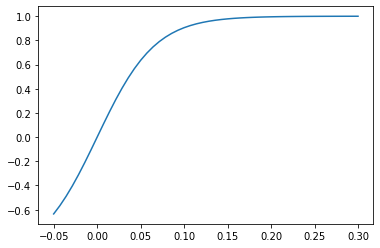

In [29]:
plt.plot(torch.linspace(-0.05,0.3,50),torch.tanh(torch.linspace(-0.05,0.3,50)*15))

In [25]:
torch.tanh(torch.tensor(0.))

tensor(0.)

In [ ]:
plt.plot(torch.linspace(-2,2,100), abs(torch.linspace(-2,2,100)+2*torch.linspace(-2,2,100)*torch.sigmoid(4*torch.linspace(-2,2,100))))

try without changing camera directions (first only from positive points)

In [19]:
proximity = tm.proximity.ProximityQuery(objectsTM)

for iter_idx in range(3000):
    #print("iter ",iter_idx)
    optimLast.zero_grad()
    optimLearn.zero_grad()
    optimUncertainty.zero_grad()
    #create data
    points = torch.tensor(objectsTM.sample(1500)).float().cuda()/100.
    points = points[(points[:,0] > 0.)] #only positive points
    #empty = (np.random.rand(2000,3)-0.5)*150
    #print("points built")
    #value = -torch.ones(len(points))
    #points = torch.cat((points,empty1),0)
    #value = torch.cat((value,torch.ones(len(empty1))),0)[:,None]
    #points to input
    sphericalInput = linAlgHelper.asSpherical(points-center.cuda())
    circularIn = circular2sinCosC(sphericalInput[:,:2].float())
    prediction1 = learnModel(circularIn)
    prediction = learnModelLastLayer(prediction1)
    uncertaintyOut = uncertaintyModel(torch.cat((circularIn,prediction.detach()),1))
    uncertainty = (uncertaintyOut[:,:-3]-prediction1.detach()).abs().sum(dim=1)
    difference = prediction-sphericalInput[:,2][:,None]
    #uncertainty should be 1 with big differences and 0 with smaller differences
    certaintyPenalty1 = (difference.detach().abs()-0.05)*uncertaintyOut[:,-3][:,None].clamp(-10,10)
    certaintyPenalty2 = (difference.detach().abs()-0.10)*uncertaintyOut[:,-2][:,None].clamp(-10,10)
    certaintyPenalty3 = (difference.detach().abs()-0.3)*uncertaintyOut[:,-1][:,None].clamp(-10,10)
    highDiff = abs(difference.detach())>1.5*abs(difference.detach().mean())
    lowDiff = abs(difference.detach())<.5*abs(difference.detach().mean())
    #penalize too big predictions more
    loss = (difference + 5.*difference * torch.sigmoid(difference*4.)).abs().sum()#
    #print("loss of points")
    #learn also from empty-points
    #sphericalInput = linAlgHelper.asSpherical(empty1-center)
    #circularIn = circular2sinCosC(sphericalInput[:,:2].float())
    #prediction1 = learnModel(circularIn)
    #prediction = learnModelLastLayer(prediction1)
    #lossEmpty = (torch.relu(prediction-sphericalInput[:,2])*10.).sum()
    #print("loss of empty")
    #lossEmpty.backward()
    uncertSum = uncertainty.sum()+certaintyPenalty1.sum()+certaintyPenalty2.sum()+certaintyPenalty3.sum()
    uncertSum.backward()
    loss.backward()
    optimLast.step()
    optimLearn.step()
    optimUncertainty.step()
    if iter_idx%50 == 0:
        print(uncertainty.detach().mean(dim=0), difference.detach().abs().mean())
        print("highDiffCertainty: ", uncertainty.detach()[highDiff[:,0]].abs().mean(dim=0), difference.detach()[highDiff[:,0]].abs().mean().item())
        print("lowDiffCertainty: ", uncertainty.detach()[lowDiff[:,0]].abs().mean(dim=0), difference.detach()[lowDiff[:,0]].abs().mean().item())



tensor(44.6407, device='cuda:0') tensor(3.5664, device='cuda:0')
highDiffCertainty:  tensor(51.1561, device='cuda:0') 7.329883575439453
lowDiffCertainty:  tensor(42.8069, device='cuda:0') 1.0919530391693115
tensor(23.2901, device='cuda:0') tensor(0.8856, device='cuda:0')
highDiffCertainty:  tensor(25.2125, device='cuda:0') 1.5340774059295654
lowDiffCertainty:  tensor(23.0464, device='cuda:0') 0.18633991479873657
tensor(19.0213, device='cuda:0') tensor(0.7171, device='cuda:0')
highDiffCertainty:  tensor(23.6243, device='cuda:0') 1.3632009029388428
lowDiffCertainty:  tensor(20.6381, device='cuda:0') 0.20075857639312744
tensor(18.8709, device='cuda:0') tensor(0.3916, device='cuda:0')
highDiffCertainty:  tensor(19.9303, device='cuda:0') 0.7311310768127441
lowDiffCertainty:  tensor(19.9198, device='cuda:0') 0.09723624587059021
tensor(16.6512, device='cuda:0') tensor(0.1214, device='cuda:0')
highDiffCertainty:  tensor(16.9194, device='cuda:0') 0.19300590455532074
lowDiffCertainty:  tensor(16

tensor(8.2511, device='cuda:0') tensor(0.0269, device='cuda:0')
highDiffCertainty:  tensor(8.5382, device='cuda:0') 0.03389707952737808
lowDiffCertainty:  tensor(7.1039, device='cuda:0') 0.0009814818622544408
tensor(7.7660, device='cuda:0') tensor(0.0230, device='cuda:0')
highDiffCertainty:  tensor(7.9026, device='cuda:0') 0.026516061276197433
lowDiffCertainty:  tensor(6.2684, device='cuda:0') 0.0006299493834376335
tensor(7.8757, device='cuda:0') tensor(0.0254, device='cuda:0')
highDiffCertainty:  tensor(8.0848, device='cuda:0') 0.032887473702430725
lowDiffCertainty:  tensor(7.1345, device='cuda:0') 0.001392242033034563
tensor(7.7069, device='cuda:0') tensor(0.0233, device='cuda:0')
highDiffCertainty:  tensor(7.8778, device='cuda:0') 0.029032811522483826
lowDiffCertainty:  tensor(7.2500, device='cuda:0') 0.0007984840776771307
tensor(7.9944, device='cuda:0') tensor(0.0256, device='cuda:0')
highDiffCertainty:  tensor(8.0038, device='cuda:0') 0.026087017729878426
lowDiffCertainty:  tensor

In [21]:
print(uncertaintyOut[:,:-3].detach().mean(), uncertaintyOut[:,-3].detach().mean())
print(difference.detach().mean())

tensor(0.0072, device='cuda:0') tensor(9.5396, device='cuda:0')
tensor(-0.0037, device='cuda:0')


In [29]:
# teste jetzt punkte aus anderen quadranten - die sicherheit sollte gering sein!

points = torch.tensor(objectsTM.sample(1500)).float().cuda()/100.
points = points[(points[:,2] < 0.)] #only negative points
#empty = (np.random.rand(2000,3)-0.5)*150
#print("points built")
#value = -torch.ones(len(points))
#points = torch.cat((points,empty1),0)
#value = torch.cat((value,torch.ones(len(empty1))),0)[:,None]
#points to input
sphericalInput = linAlgHelper.asSpherical(points-center.cuda())
circularIn = circular2sinCosC(sphericalInput[:,:2].float())
prediction1 = learnModel(circularIn)
prediction = learnModelLastLayer(prediction1)
uncertaintyOut = uncertaintyModel(torch.cat((circularIn,prediction.detach()),1))
uncertainty = (uncertaintyOut[:,:-3]-prediction1.detach()).abs().sum(dim=1)
difference = prediction-sphericalInput[:,2][:,None]

print((uncertaintyOut[:,:-3]-prediction1.detach()).mean(), uncertaintyOut[:,-3].mean())
print(difference.detach().mean())

tensor(-0.0107, device='cuda:0', grad_fn=<MeanBackward0>) tensor(7.4758, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0167, device='cuda:0')


In [49]:
points

tensor([], device='cuda:0', size=(0, 3))

In [31]:
pointcloudTarget = (objectsTM.sample(1500))/100.-center.numpy()

pointcloudT = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(pointcloudTarget))
colors = np.ones_like(pointcloudTarget).astype(np.float64)
colors[:,2] = colors[:,0]*0.
colors[:,0] = colors[:,1]*0.
pointcloudT.colors = o3d.utility.Vector3dVector(colors)

vertices, faces = meshIt(torch.nn.Sequential(learnModel,learnModelLastLayer))
learnMesh = tm.Trimesh(vertices=vertices, faces=faces)

pointcloudMesh = learnMesh.sample(1000)
pointcloudE = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(pointcloudMesh))
colors = np.ones_like(pointcloudMesh).astype(np.float64)
colors[:,1] = colors[:,0]*0.
colors[:,2] = colors[:,1]*0.
pointcloudE.colors = o3d.utility.Vector3dVector(colors)


o3d.visualization.draw_geometries([ pointcloudT,pointcloudE])

# Neubewertung des Values der Punkte bei sicherer Rekonstruktion  
Eine sichere Rekonstruktion ausserhalb der Bounds sollte die Bounds verschieben.  
Starke Unsicherheit sollte ebenfalls die Bounds ein wenig nach aussen schieben.  (hier hat das Netz niemals Punkte gesehen).
Eine sichere aber fehlerhafte Rekonstruktion sollte viel Value erhalten und die Bounds nach innen führen.  
Eine sichere Rekonstruktion innerhalb der Bounds sollte ebenfalls viel Value erzeugen und die Bounds an Ort und Stelle lassen.

# mit interaktion zwischen Mehreren Objekten mit Bounds
Points Gained werden durch andere Objekte maskiert - sofern ihr inneres Loss 0 beträgt (oder sehr gering ist)   
Überschneidung von Objekten untereinander muss bestraft werden (inner Loss von beiden erhöhen?)  
Wird wohl objektorientiert aufgebaut werden müssen

In [ ]:
class NeuralBound:
    pointOccupationVector = torch.Tensor([[]])
    neuralBoundList = []
    unoccupiedRegions = torch.Tensor([[]])
    
    def createOccupationVector(points):
        neuralBound.pointOccupationVector = torch.zeros_like(points[:,0])
        for volume in neuralBound.neuralBoundList:
            volume.insideOccupation(points)
        neuralBound.unoccupiedRegions = neuralBound.pointOccupationVector == 0
        neuralBound.pointOccupationVector = neuralBound.pointOccupationVector > 1
    
    def __init__(self, 
                 additionalBounds = None,
                 boundsize = 1.,
                 center=torch.Tensor([[0.,0.,0.]]), 
                 verbose=True,
                centerLR = 0.01,
                boundsLR = 0.01):
        self.center = center.cuda()
        self.bounds = torch.Tensor([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.],[-1.,0.,0.],[0.,-1.,0.],[0.,0.,-1.]])*boundsize
        if additionalBounds is not None:
            self.bounds = torch.cat((self.bounds,additionalBounds),0)
        self.bounds = self.bounds.cuda()
        self.name = "newBound"
        self.verbose = verbose
        self.center.requires_grad = True
        self.bounds.requires_grad = True
        self.centerOptim = torch.optim.Adam([self.center], lr=centerLR)
        self.boundsOptim = torch.optim.Adam([self.bounds], lr=boundsLR)
        neuralBound.neuralBoundList.append(self)
        if self.verbose:
            print("{} was created at {}".format(self.name, self.center.cpu().detach()))
    
    def getVolume(self):
        return (self.bounds[0]-self.bounds[3])[0].detach()*(self.bounds[1]-self.bounds[4])[1].detach()*(self.bounds[2]-self.bounds[5])[2].detach()
    
    def clampBounds(self):
        self.bounds[0,0].clamp(-99999,-0.01)
        self.bounds[0,1] = 0.
        self.bounds[0,2] = 0.
        self.bounds[3,0].clamp(0.01,99999)
        self.bounds[3,1] = 0.
        self.bounds[3,2] = 0.
        self.bounds[1,1].clamp(-99999,-0.01)
        self.bounds[1,0] = 0.
        self.bounds[1,2] = 0.
        self.bounds[4,1].clamp(0.01,99999)
        self.bounds[4,0] = 0.
        self.bounds[4,2] = 0.
        self.bounds[2,2].clamp(-99999,-0.01)
        self.bounds[2,0] = 0.
        self.bounds[2,1] = 0.
        self.bounds[5,2].clamp(0.01,99999)
        self.bounds[5,0] = 0.
        self.bounds[5,1] = 0.
        
    def insideOccupation(self, points):
        '''Takes only surfacepoints (n,3)'''
        with torch.no_grad():
            centeredPoints = points-self.center
            boundsTest = linAlgHelper.getPointDistances2PlaneNormal(centeredPoints[None,:,:], self.bounds[None,:,:])[0]
            inside = boundsTest>0
            completeInner = inside.sum(dim=1)==inside.shape[1]
            neuralBound.pointOccupationVector += completeInner*1
    
    def boundsTest(self, surfacepoints, emptyVectors):
        '''gets tensor(n,3) surfacespoints (surface ) with (n,1) values (1 for surface, -1 for empty)'''
        points = torch.cat((surfacepoints,emptypoints),0)
        centeredPoints_surface = surfacepoints-self.center
        centeredPoints_empty = emptypoints-self.center
        boundsTest_surface = linAlgHelper.getPointDistances2PlaneNormal(centeredPoints_surface[None,:,:], self.bounds[None,:,:])[0]
        boundsTest_empty = linAlgHelper.getPointDistances2PlaneNormal(centeredPoints_empty[None,:,:], self.bounds[None,:,:])[0]
        with torch.no_grad():
            size = self.bounds[:6].detach().abs().max()
            inside_surface = boundsTest_surface>0
            inside_empty = boundsTest_empty>0
            near_surface = boundsTest<-0.5*size 
            importance_surface = 0.1*size/(0.1*size+abs(boundsTest_surface)) 
            importance_empty = 0.1*size/(0.1*size+abs(boundsTest_empty)) 
            completeInner_surface = importance_surface.sum(dim=1)==importance_surface.shape[1]
            completeInner_empty = inside_empty.sum(dim=1)==inside_empty.shape[1]
            completeNear_surface = near_surface.sum(dim=1)==near_surface.shape[1]
        insideGradient_surface = torch.sigmoid(boundsTest_surface*3./(size))
        insideGradient_empty = torch.sigmoid(boundsTest_empty*3./(size))
        outsideGradient_surface = -torch.sigmoid(boundsTest_surface/(size))
        outsideGradient_empty = -torch.sigmoid(boundsTest_empty/(size))
        #recalculation of value (overlap and reproducing accuracy/certainty)
        #overlap penalty
        value[pointOccupationVector] = -0.1 #smaller negative value to encourage seamless reconstructions
        
        missedPointsLoss = (((1.-inside)*near*importance*outsideGradient*)[value[:,0]<0])
        # for the inner loss: errors near a plane are important, but the gradient of the error should shrink, the nearer it gets
        wrongValues = value*completeInner[:,None]
        innerLoss= (importance**2*wrongValues*insideError)[value[:,0]>0]
        #outside = 1.-hardCutOff[0,:]
        #greedyGains = torch.relu(-value[:,0]*outside* (1.-softCutOff[0,:])).sum() #vorhersagen aussen erreichen
        #innerLoss = torch.relu(value[:,0]*((hardCutOff*softCutOff)[0,:])).sum()  #fehler innen vermeiden
        #expansionGain = - #expansionsdrang
        #bestSeparation = -((-value)*(insideError-0.5)*importance**2)[near]
        error = errorGreed.sum() +100*innerLoss.sum()#+ bestSeparation.sum()
        error.backward()
        
    def show(self):
        #get size
        data = torch.rand(50000,3)*2.*size-size
        boundsTest = linAlgHelper.getPointDistances2PlaneNormal(data[None,:,:], self.bounds.detach()[None,:,:])[0]
        inside = boundsTest>0
        inside = inside.sum(dim=1)==inside.shape[1]
        filtered = data[inside]
        filteredIdx = torch.arange(len(filtered))
        hull = ConvexHull(filtered)
        verts_ = torch.tensor(hull.vertices)
        vertIdx = torch.arange(len(verts_))
        filteredIdx[verts_.long()] = vertIdx
        faces_ = torch.tensor(hull.simplices)
        vertices, faces =  filtered[verts_.long()]+center.detach(), filteredIdx[faces_.long()]
        mesh = tm.Trimesh(vertices=vertices+self.center.detach().cpu(), faces=faces)
        #visualisieren der Zielfiguren
        pointcloudPoints = mesh.sample(max(int(500.*size),20))
        pointcloudO3d = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(pointcloudPoints))
        colors = np.ones_like(pointcloudPoints).astype(np.float64)
        colors[:,2] = np.random.rand()
        colors[:,1] = np.random.rand()
        colors[:,0] = np.random.rand()
        pointcloudO3d.colors = o3d.utility.Vector3dVector(colors)
        return(pointcloudO3d)
    
    def trainStep(points, camPosition):
        '''Points as Vector (n,3)     camPosition as vector 3'''
        NeuralBound.createOccupationVector(points)
        #create empty points
        emptyVectors = (camPosition[None,None,:].cuda()-points.cuda()).reshape(-1,3)
        emptyVectors = emptyVectors/((emptyVectors**2).sum(dim=-1))[:,None]**0.5
        emptyStart = (points.reshape(-1,3).cuda()+emptyVectors*0.09)
        empty1 = torch.cat((emptyStart,points.reshape(-1,3).cuda()+emptyVectors*0.15),0)
        empty1 = torch.cat((empty1,points.reshape(-1,3).cuda()+emptyVectors*0.35),0)
        for volume in neuralBound.neuralBoundList:
            volume.boundsTest(points, emptypoints)
        
    def isZero(self):
        #get size
        if size < 0.05:
            #delete self from volumeList
            
            
#new neuralVolumes should be initialized when there is no "growing/learning" neural Volume in a Region


            
    

# spawnen von neuen Objekten bei Bedarf